# Pretrained HOG Detector

In [26]:
import json
import os
import cv2
import numpy as np
import argparse
import ipdb
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from imutils.object_detection import non_max_suppression

In [40]:
def do_NMS(bboxes, scores, overlapThresh):
    # changes x,y,w,h to x,y,x2,y2
    for idx in range(bboxes.shape[0]):
        bboxes[idx, 2] += bboxes[idx, 0]
        bboxes[idx, 3] += bboxes[idx, 1]
    
    bboxes_nms = non_max_suppression(bboxes, probs=scores.reshape(-1), overlapThresh=overlapThresh)
    
    # get scores for these bounding boxes
    scores_nms = []
    for bb in bboxes_nms:
        scores_nms.append(scores[(bb == bboxes).mean(axis=1) == 1][0])
    scores_nms = np.array(scores_nms).reshape(-1)

    # changes x,y,x2,y2 to x,y,w,h
    for idx in range(bboxes_nms.shape[0]):
        bboxes_nms[idx, 2] = bboxes_nms[idx, 2] - bboxes_nms[idx, 0] 
        bboxes_nms[idx, 3] = bboxes_nms[idx, 3] - bboxes_nms[idx, 1] 

    return bboxes_nms, scores_nms

In [41]:
test_json = json.loads(open("PennFudanPed_val.json",'r').read())
img_dicts = test_json['images']

In [42]:
annotations = test_json['annotations'] # this is ONLY used for comparison of predicted bboxes
annotations = pd.json_normalize(annotations)

In [43]:
hog = cv2.HOGDescriptor()
hog.setSVMDetector(hog.getDefaultPeopleDetector())

In [44]:
img_dict = img_dicts[0]
img_dict

{'file_name': 'PennFudanPed/PNGImages/PennPed00046.png',
 'height': 348,
 'width': 534,
 'id': 0}

In [45]:
img = cv2.imread(os.path.join("./", img_dict['file_name']))

In [46]:
img.shape

(348, 534, 3)

In [47]:
bboxes, scores = hog.detectMultiScale(img) # , winStride=(2, 2), padding=(10, 10), scale=1.02)

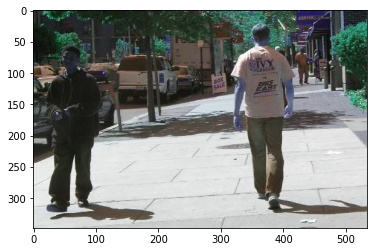

In [48]:
plt.imshow(img)

In [49]:
print(bboxes)
print(scores)

[[151  23  93 187]
 [288  29 155 308]]
[[0.50648117]
 [1.23230827]]


In [50]:
list(annotations.loc[annotations['image_id'] == img_dict['id']]['bbox'])

[[20.0, 57.0, 90.0, 265.0],
 [317.0, 21.0, 102.0, 297.0],
 [420.0, 61.0, 20.0, 57.0]]

In [51]:
bboxes, scores = do_NMS(bboxes, scores, overlapThresh=0.8) # bboxes.dtype is int, scores.dtype is float

In [52]:
print(bboxes)
print(scores)

[[288  29 155 308]
 [151  23  93 187]]
[1.23230827 0.50648117]


# faster rcnn

In [2]:
from ipdb import set_trace
from tqdm import tqdm
import json
import os
import pandas as pd
import numpy as np
import argparse
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import PIL.Image as Image

In [3]:
def get_device(gpu_no=0):
	if torch.cuda.is_available():
		torch.cuda.set_device(gpu_no)
		return torch.device('cuda:{}'.format(gpu_no))
	else:
		return torch.device('cpu')

class PennFudan_dataset(Dataset):
    def __init__(self, root, test_json):
        super(PennFudan_dataset, self).__init__()
        self.root = root
        
        self.img_dicts = test_json['images']
        
        self.normalize_trnsfrm = transforms.Compose([transforms.ToTensor()])

    def __getitem__(self, index):
        img_dict = self.img_dicts[index]
        img = Image.open(os.path.join(self.root, img_dict["file_name"]))
        x = self.normalize_trnsfrm(img)
        return x, img_dict["id"]
  
    def __len__(self):
        return len(self.img_dicts)

In [4]:
device = get_device()
test_json = json.loads(open("/home/shubham/PedestrianDetection/PennFudanPed_val.json",'r').read())

In [9]:
# pretrained faster rcnn model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, progress=True, num_classes=91, pretrained_backbone=True)
model = model.to(device)
model.eval()

# dataset to evaluate
testset = PennFudan_dataset("/home/shubham/PedestrianDetection", test_json)
testloader = DataLoader(testset, batch_size=1, shuffle=False)

# predictions will be saved iteratively
predictions = []
no_pred_count = 0
nms_count = 0

# for saving images with predicted bboxes, and comparing them with annotations
annotations = test_json['annotations'] # this is ONLY used for comparison of predicted bboxes
annotations = pd.json_normalize(annotations)
save_preds_dir = os.path.join("/home/shubham/PedestrianDetection", "predictions_faster_rcnn")
if os.path.exists(save_preds_dir) == False:
    os.mkdir(save_preds_dir)
transfrm = transforms.ToPILImage()

In [10]:
imgs, img_ids = next(iter(testloader))

In [13]:
print(imgs.shape, img_ids.shape)

torch.Size([1, 3, 348, 534]) torch.Size([1])


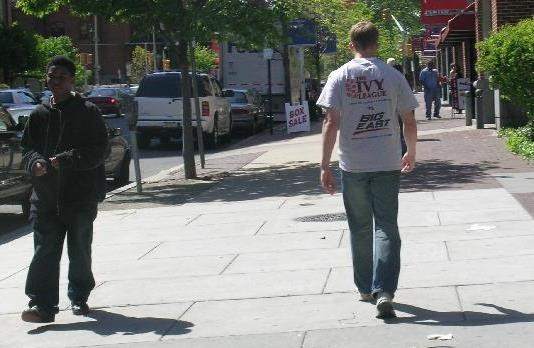

In [12]:
transfrm(imgs[0])